# Projeto 2: Segmentação de Clientes

# Importação de Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Dados

In [3]:
df = pd.read_csv("segmentacao.csv")
df.head()

,customer_id,age,income,spending_score,region
0,CUST_1,56,23343,81,Oeste
1,CUST_2,69,33500,5,Sul
2,CUST_3,46,73222,29,Leste
3,CUST_4,32,49375,4,Oeste
4,CUST_5,60,29662,10,Oeste


# Valores faltantes

In [4]:
# Verificando se existem valores faltantes.

df.isnull().sum()

,0
customer_id,0
age,0
income,0
spending_score,0
region,0


## Outliers

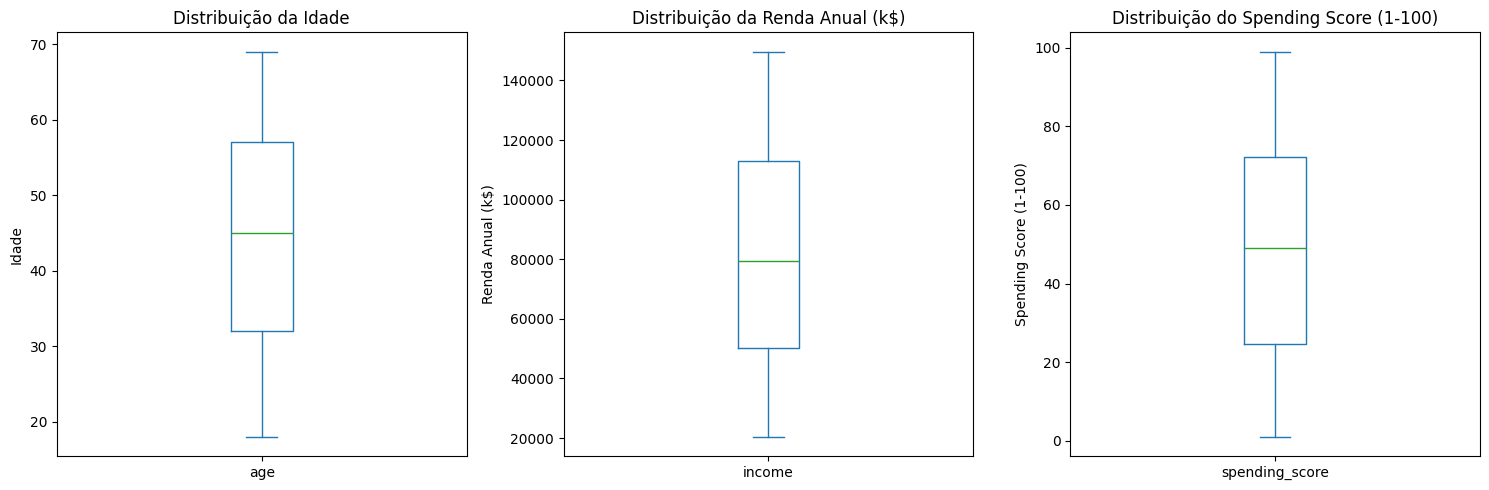

In [38]:
# Verificando a existência de outliers nas variáveis 'age', 'income' e 'spending_score'
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['age'].plot(kind='box')
plt.title('Distribuição da Idade')
plt.ylabel('Idade')

plt.subplot(1, 3, 2)
df['income'].plot(kind='box')
plt.title('Distribuição da Renda Anual (k$)')
plt.ylabel('Renda Anual (k$)')

plt.subplot(1, 3, 3)
df['spending_score'].plot(kind='box')
plt.title('Distribuição do Spending Score (1-100)')
plt.ylabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()


### Tranformar a variável Region em Dummies

In [5]:
df = pd.get_dummies(df, columns=['region'], drop_first=True)
df.head()

,customer_id,age,income,spending_score,region_Norte,region_Oeste,region_Sul
0,CUST_1,56,23343,81,False,True,False
1,CUST_2,69,33500,5,False,False,True
2,CUST_3,46,73222,29,False,False,False
3,CUST_4,32,49375,4,False,True,False
4,CUST_5,60,29662,10,False,True,False


### Análise Exploratória

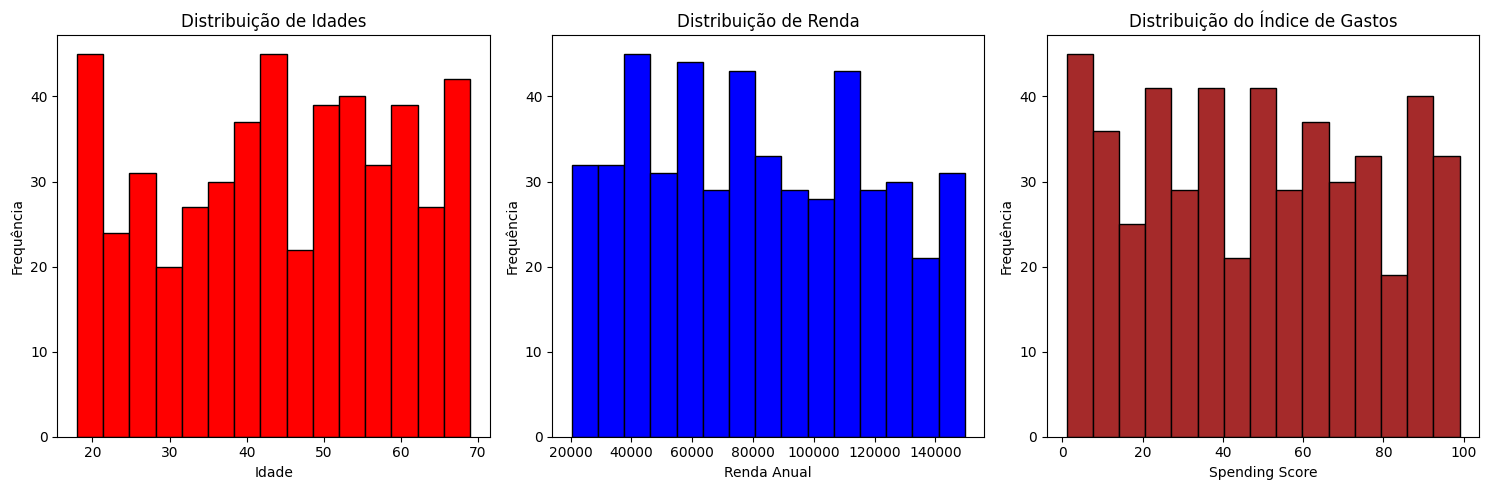

In [39]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(df['age'], bins=15, color='red', edgecolor='black')
plt.title("Distribuição de Idades")
plt.xlabel("Idade")
plt.ylabel("Frequência")

plt.subplot(1, 3, 2)
plt.hist(df['income'], bins=15, color='blue', edgecolor='black')
plt.title("Distribuição de Renda")
plt.xlabel("Renda Anual")
plt.ylabel("Frequência")

plt.subplot(1, 3, 3)
plt.hist(df['spending_score'], bins=15, color='brown', edgecolor='black')
plt.title("Distribuição do Índice de Gastos")
plt.xlabel("Spending Score")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()

### Exclui ID

In [7]:
#Excluir a coluna "ID" por não ter valor semântico
X = df.drop(columns=['customer_id'])
X.head()

,age,income,spending_score,region_Norte,region_Oeste,region_Sul
0,56,23343,81,False,True,False
1,69,33500,5,False,False,True
2,46,73222,29,False,False,False
3,32,49375,4,False,True,False
4,60,29662,10,False,True,False


### Padronização

In [8]:
#Coloca os dados em uma escala parecida para evitar que estejam em escalas discrepantes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.78423339, -1.60481921,  1.13143949, -0.62360956,  1.92794739,
        -0.59583014],
       [ 1.6496862 , -1.32607195, -1.50546334, -0.62360956, -0.51868635,
         1.67833069],
       [ 0.11850046, -0.23594703, -0.67275718, -0.62360956, -0.51868635,
        -0.59583014],
       ...,
       [ 0.85080668,  0.23520912,  1.37431212, -0.62360956, -0.51868635,
        -0.59583014],
       [ 1.18367315, -0.2604544 ,  1.02735122, -0.62360956, -0.51868635,
         1.67833069],
       [-1.74555174,  1.66305815, -0.56866891, -0.62360956, -0.51868635,
        -0.59583014]])

### PCA

In [9]:
#Aqui rodamos o PCA para buscar "n" melhores componentes mantendo 95% da variância do conjunto de dados original
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"Número de componentes principais: {X_pca.shape[1]}")

Número de componentes principais: 6


In [10]:
X_pca

array([[-0.80263914,  2.56931754,  0.27616069,  0.02913605, -1.1702955 ,
         0.4890585 ],
       [-1.6074983 , -1.17169063,  2.05045356, -1.01176719, -0.94687467,
         0.37357134],
       [-0.099575  , -0.04171478,  0.45748823, -0.51311611,  0.1123418 ,
        -1.01901617],
       ...,
       [ 0.05970248,  0.36453105, -0.00257715,  1.33139897, -0.95362536,
        -0.92864883],
       [-1.31936217, -0.85440867,  0.30788189,  1.05711074, -1.4614048 ,
         0.42470978],
       [ 0.22821843, -0.60156486, -1.22072198,  0.10463532,  1.97036319,
        -1.16259618]])

### Número Ideal de Clusters

In [11]:
inertia = []  # Lista para armazenar os valores de inércia para cada valor de k (nº de clusters)
silhouette_scores = []  # Lista para armazenar os valores do índice de silhueta para cada k
cluster_range = range(2, 10)  # Intervalo de número de clusters que será testado (de 2 a 9)

for k in cluster_range:  # Para cada valor de k no intervalo definido
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Cria o modelo KMeans com k clusters
    kmeans.fit(X_pca)  # Treina o modelo com os dados reduzidos via PCA
    inertia.append(kmeans.inertia_)  # Armazena a inércia (soma das distâncias dos pontos ao centro do cluster)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))  # Calcula e armazena o índice de silhueta (qualidade dos agrupamentos)


In [12]:
for k, sil_score in zip(cluster_range, silhouette_scores):  # Para cada valor de k e seu respectivo Silhouette Score
    print(f"Clusters: {k}, Silhouette Score: {sil_score:.4f}")  # Exibe o número de clusters testado e o score com 4 casas decimais


Clusters: 2, Silhouette Score: 0.2256
Clusters: 3, Silhouette Score: 0.3060
Clusters: 4, Silhouette Score: 0.3075
Clusters: 5, Silhouette Score: 0.2660
Clusters: 6, Silhouette Score: 0.2778
Clusters: 7, Silhouette Score: 0.2826
Clusters: 8, Silhouette Score: 0.2810
Clusters: 9, Silhouette Score: 0.2790


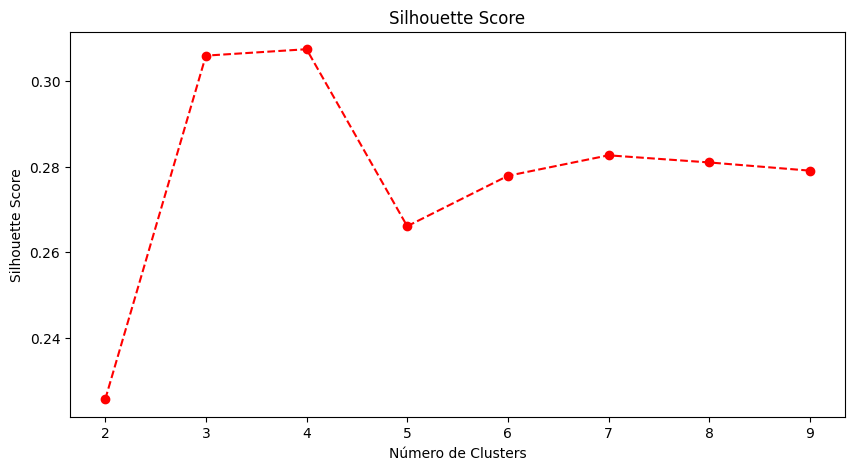

In [18]:
# silhouette score
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='red')
plt.title("Silhouette Score")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.show()

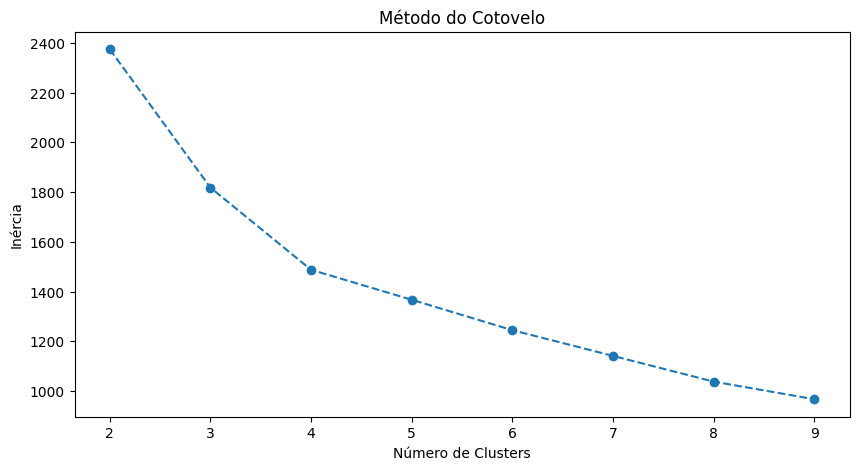

In [14]:
# método do cotovelo
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title("Método do Cotovelo")
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")
plt.show()

### Gerar Clusters e Atribuir ao Cliente

In [15]:
#Como a métrica Silhouete Score e os gráficos de Silhouete e Cotovelo apontaram o número ideal de clusters sendo 4, utilizaremos essa quantidade no K-MEANS

k = 4  # Define o número de clusters desejado (neste caso, 4)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Cria o modelo KMeans com 4 clusters e inicialização estável
df['cluster'] = kmeans.fit_predict(X_pca)  # Aplica o modelo aos dados (reduzidos via PCA) e atribui os rótulos de cluster ao DataFrame
df.head(10)  # Exibe as 10 primeiras linhas do DataFrame com a nova coluna 'cluster'


,customer_id,age,income,spending_score,region_Norte,region_Oeste,region_Sul,cluster
0,CUST_1,56,23343,81,False,True,False,2
1,CUST_2,69,33500,5,False,False,True,1
2,CUST_3,46,73222,29,False,False,False,3
3,CUST_4,32,49375,4,False,True,False,2
4,CUST_5,60,29662,10,False,True,False,2
5,CUST_6,25,36964,56,False,True,False,2
6,CUST_7,38,133429,17,True,False,False,0
7,CUST_8,56,141692,74,False,False,True,1
8,CUST_9,36,79638,17,True,False,False,0
9,CUST_10,40,93666,84,False,False,True,1


### Visualização

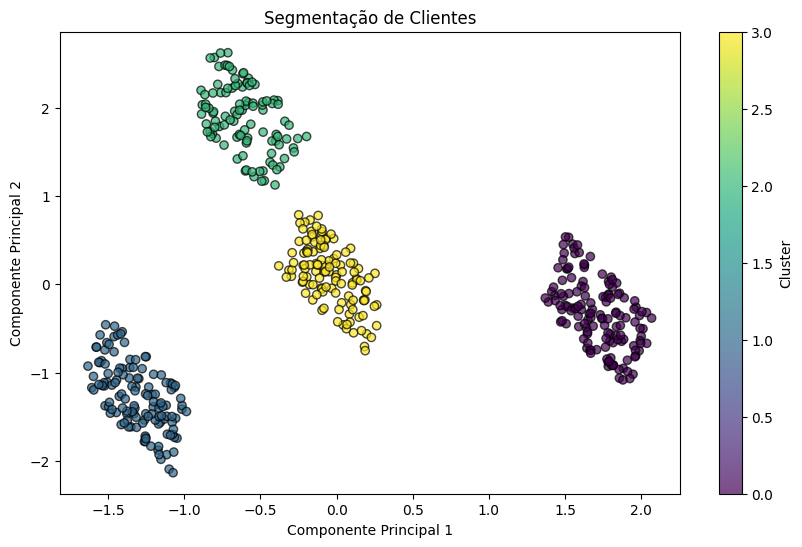

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.7, edgecolors='black')
plt.title("Segmentação de Clientes")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")
plt.show()

##Calculando a Média de Gastos por Cluster

In [22]:
#Média de gastos por cluster.

average_spending_by_cluster = df.groupby('cluster')['spending_score'].mean()
print("Média do Índice de Gastos por Cluster:")
average_spending_by_cluster

Média do Índice de Gastos por Cluster:


,spending_score
cluster,
0,47.514286
1,44.511450
2,51.047170
3,51.227642
